In [48]:
import gym
import numpy as np
import random
import math
from itertools import count

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


env = gym.envs.make("MountainCarContinuous-v0")
env._max_episode_steps = 2000
# print("Action space: ", env.action_space, "\nHigh: ", env.action_space.high, "Low: ", env.action_space.low)
# print("Observation space: ", env.observation_space, "\nHigh: ", env.observation_space.high, "Low: ", env.observation_space.low)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/mquan/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Abstract class of Baseline & Policy  
Key point of this class is the definition of the featurizer based on Radial Basis Function (RBF). This featurizer is used for featurizing state before calculating the value of the Baseline or the action produce by the Policy.

In [49]:
class PolicyGradient(object):
    def __init__(self, num_features, _examples):
        '''
        num_features: define len of weights vector of the linear model (used as either Actor or Critic)
        _examples: sample for either observation space or (obs, act) space to normalize the scaler to 
                    zero mean & unit variance
        '''
        assert num_features % 4 == 0  # 4 featurizers
        self.weights = np.zeros(num_features)
        # define & normalize scaler
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(_examples)
        # define featurizer
        num_components = num_features // 4
        self.featurizer = state_featurizer = sklearn.pipeline.FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=num_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=num_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=num_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=num_components))
                ])
        self.featurizer.fit(self.scaler.transform(_examples))
        
    def featurize(self, *argv):
        '''
        Accepted input: state or state, action
        '''
        assert len(argv) in [1, 2]
        if len(argv) == 2:
            # featurize a (state, action) pair
            scaled = self.scaler.transform([np.append(argv[0], argv[1])])
        else:
            # featurize a state
            scaled = self.scaler.transform([argv[0]])
        # invoke the featurizer
        featurized = self.featurizer.transform(scaled)
        return featurized[0]

## Definition of the Baseline
The Baseline is a **Linear** Function Approximator. It aims to estimate the state value function V(s)

In [50]:
class BaseLine(PolicyGradient):
    def __init__(self, num_features, lr=1e-3):
        observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
        super().__init__(num_features, observation_examples)
        self.lr =  1e-3
    
    def cal_state_value(self, state):
        return self.weights.dot(self.featurize(state))
    
    def update_weights(self, td_error, state, td_correction):
        self.weights += self.lr * td_error * self.featurize(state) - self.lr * td_correction

## ACTOR - Definition of the Policy
Policy is a **Linear** function calculating the action which is then taken by the agent, given the agent's current state (s). Hence, the Policy is deterministic.

In [51]:
class Policy(PolicyGradient):
    def __init__(self, num_features, lr=1e-3):
        observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
        super().__init__(num_features, observation_examples)
        self.lr = 1e-3
    
    def cal_action(self, state):
        return self.weights.dot(self.featurize(state))
    
    def cal_grad_policy(self, state):
        '''
        calculate the gradient of the policy w.r.t its weights. 
        The policy is chosen to be a linear combination of weights & features vector,
        so its grad is just the features vector
        '''
        return self.featurize(state)
    
    def update_weights(self, grad_policy, critic_weights):
        assert critic_weights.shape[0] == grad_policy.shape[0]  # to ensure grad_policy & weights of critic are size compatible
        self.weights += self.lr * grad_policy * grad_policy.dot(critic_weights)
                                 

# CRITIC - Action value function approximator
The action value fucntion approximator is used as the **Critic**. It's chosen to be *compatible* with Deterministic Policy Gradient.

In [52]:
class CompatibleQFunction(object):
    def __init__(self, num_features, lr=1e-3):
        self.weights = np.zeros(num_features)
        self.lr = lr
        
    def cal_action_value(self, _action, chosen_action, grad_policy, baseline_value):
        '''
        _action is of the 2nd input of Q(s, a)
        state s is implied in chosen_action, grad_policy & baseline value
        '''
        assert grad_policy.shape[0] == self.weights.shape[0]  # ensure size compatible
        return (_action - chosen_action) * grad_policy.dot(self.weights) + baseline_value
    
    def featurize(self, grad_policy, behaviour_action, chosen_action):
        return grad_policy * (behaviour_action - chosen_action)
    
    def update_weights(self, td_error, grad_policy, behaviour_action, chosen_action, td_correction):
        self.weights += self.lr * td_error * (behaviour_action - chosen_action) * grad_policy - \
                        self.lr * td_correction
        

# Approximator of 2 Expectations in Mean Square Bellman Projected Error (MSBPE
Another set of parameters $u$ is used to estimate two expectation in MSBPE
\begin{equation*}
u \approx \mathbb{E}\left[\phi \phi^T \right]^{-1}\mathbb{E}\left[\delta \phi \right]
\end{equation*}
With $\phi = \phi(s_t, a_t)$ is the features vector of state-action pair, $\delta$ is the (one-step) TD error.

In [53]:
class MSBPEestimator(object):
    def __init__(self, num_features, lr=1e-3):
        self.weights = np.zeros(num_features)
        self.lr = lr
    
    def update_weights(self, td_error, state_act_features_vect):
        self.weights += self.lr * (td_error - state_act_features_vect.dot(self.weights)) * state_act_features_vect

# Behaviour Policy
Beahviour policy is set to be a Gaussian distribution with fixed standard deviation

In [54]:
SIGMA = 0.25 * (env.action_space.high[0] - env.action_space.low[0])
def behaviour_policy(chosen_action):
    return np.random.normal(chosen_action)

# Training 

In [55]:
NUM_FEATURES = 4 * 30
GAMMA = 0.99

In [56]:
def checkout_actor(i_episode, _actor):
    state = env.reset()
    ans = 0
    for step in count():
        act = _actor.cal_action(state)
        new_state, reward, done, _= env.step([act])
        if new_state[0] > 0.45:
            done = True
            reward = 1.
        if done:
            print("Episode %d [ACTOR] Finish after %d step" % (i_episode, step+1))
            print("-------------------------------------")
            ans = step + 1
            break
        # Move on 
        state = new_state
    return ans

## Statistic

In [57]:
abs_u_per_episode = []
actor_step_per_episode = []

In [58]:
# Init Actor, Critic, & Baseline function
actor = Policy(NUM_FEATURES)
critic = CompatibleQFunction(NUM_FEATURES)
baseline = BaseLine(NUM_FEATURES)
u = MSBPEestimator(NUM_FEATURES)  # for TD correction

max_episode = 61
for i_episode in range(max_episode):
    state = env.reset()
    chosen_act = actor.cal_action(state)
    for step in count():
        # Find behaviour action
        behave_act = behaviour_policy(chosen_act)
        # Take behave_act, observe new state & reward
        new_state, reward, done, _ = env.step([behave_act])
        if new_state[0] > 0.45:
            done = True
            reward = 1.
        # calculate new action using actor
        new_chosen_act = actor.cal_action(new_state)
        # calculate TD error
        grad_policy = actor.cal_grad_policy(state)
        new_grad_policy = actor.cal_grad_policy(new_state)
        
        if not done:
            td_target = reward + GAMMA * critic.cal_action_value(new_chosen_act, 
                                                                new_chosen_act, 
                                                                new_grad_policy, 
                                                                baseline.cal_state_value(new_state))
        else:
            td_target = reward
            
        td_error = td_target - critic.cal_action_value(behave_act,
                                                      chosen_act,
                                                      grad_policy,
                                                      baseline.cal_state_value(state))
        # Update weights
        actor.update_weights(grad_policy, critic.weights)
        # calculate correction term for critic & baseline (i.e. approximation of state value V(s))
        state_behaveAct_features_vect = critic.featurize(grad_policy, behave_act, chosen_act)
        
        critic_td_correction = 0
        baseline_td_correction = GAMMA * baseline.featurize(new_state) * \
                                        state_behaveAct_features_vect.dot(u.weights)
        
        critic.update_weights(td_error, grad_policy, behave_act, chosen_act, critic_td_correction)
        baseline.update_weights(td_error, state, baseline_td_correction)
        u.update_weights(td_error, state_behaveAct_features_vect)
        
        if done:
            print("Episode %d finishes after %d steps" % (i_episode, step + 1))
            print("-------------------------------------")
            break
        else:
            if step % 500 == 0: print("TD error:\t%.4f" % td_error)
        
        # Move on
        state = new_state
        chosen_act = new_chosen_act
        
    if i_episode % 10 == 0:
        actor_step_per_episode.append(checkout_actor(i_episode, actor))
    # store sum square of u
    abs_u_per_episode.append(np.absolute(u.weights).sum())
        

TD error:	-0.5121
TD error:	-0.0072
TD error:	-0.0035
Episode 0 finishes after 1369 steps
-------------------------------------
Episode 0 [ACTOR] Finish after 2000 step
-------------------------------------
TD error:	-0.0053
TD error:	-0.0642
TD error:	-0.0938
TD error:	-0.4265
Episode 1 finishes after 2000 steps
-------------------------------------
TD error:	-0.2080
TD error:	0.0058
TD error:	-0.0251
TD error:	0.0077
Episode 2 finishes after 2000 steps
-------------------------------------
TD error:	-0.0054
TD error:	-0.0664
TD error:	-0.1579
Episode 3 finishes after 1271 steps
-------------------------------------
TD error:	-0.0735
TD error:	0.0101
TD error:	-0.0433
TD error:	-0.0093
Episode 4 finishes after 1718 steps
-------------------------------------
TD error:	0.0052
TD error:	-0.1450
TD error:	-0.5314
TD error:	-0.0787
Episode 5 finishes after 1644 steps
-------------------------------------
TD error:	0.0081
TD error:	-0.1100
TD error:	-0.0672
Episode 6 finishes after 1482 st

## Statistic

In [59]:
def plotValueFunc(value_approx):
    x_vect = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=50)
    xdot_vect = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=50)
    x, xdot = np.meshgrid(x_vect, xdot_vect)
    state_value = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            state = np.array([x[i, j], xdot[i, j]])
            state_value[i, j] = value_approx.cal_state_value(state)
    # plot Value function
    fig = plt.figure(100)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x, xdot, -state_value, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    plt.show()

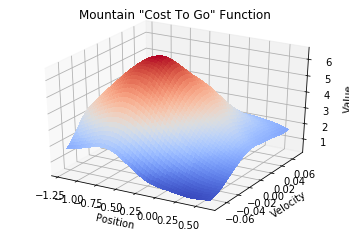

In [60]:
plotValueFunc(baseline)

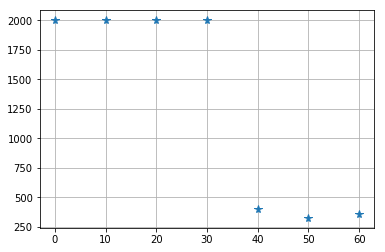

In [62]:
plt.figure(2)
plt.plot([0, 10, 20, 30, 40, 50, 60], actor_step_per_episode, '*', markersize=8)
plt.grid()
plt.show()

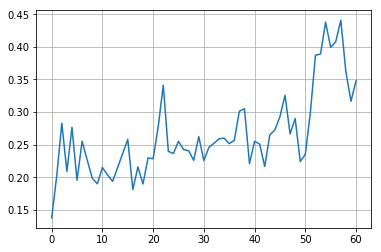

In [63]:
plt.figure(5)
plt.plot(abs_u_per_episode)
plt.grid()
plt.show()